In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value(data={self.data})'
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
        
        return out
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"

        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
                                                                            
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other
        

    def tanh (self) :
        x = self.data
        t = (math.exp (2*x) - 1) /(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        #topological sort
        topo = []
        visited = set ()
        def build_topo(v):
            if v not in visited: 
                visited.add (v)
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0); f.label = 'f'
L = d * f; L.label = 'L'


In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes: 
            nodes.add (v)
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot (root):
    dot = Digraph (format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot. node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node (name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect ni to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

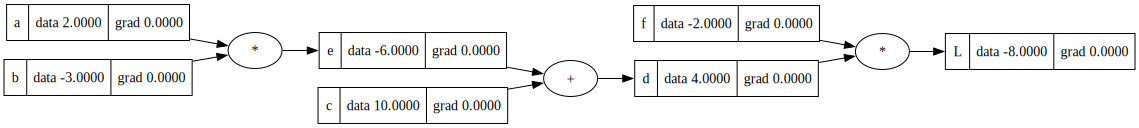

In [4]:
draw_dot(L)

In [5]:
# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a * b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2.0); f.label = 'f'
# L = d * f; L.label = 'L'

# manual backpropagation
# dL/dL = 1
# dL/dd : L = d * f => dL/dd = f = -2.0
# dL/df : L = d * f => dL/df = d = 4.0
# dL/de (using chain rule) : dL/de = dL/dd * dd/de = f * (e + c)' = f * (1 + 0) = f = -2.0
# dL/dc = dL/dd * dd/dc = f * (e + c)' = f * (0 + 1) = f = -2.0
# dL/da = dL/de * de/da = f * (a*b)' = f * b = -2.0 * -3.0 = 6.0
# dL/db = dL/de * de/db = f * (a*b)' = f * a = -2.0 * 2.0 = -4.0
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [6]:
# small optimisation -> incrasing values by a small amount of the gradient
# this will lead in increasing of the output : L

h = 0.01
a.data += a.grad * h
b.data += b.grad * h
c.data += c.grad * h
f.data += f.grad * h
e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


In [7]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value (0.0, label='x2')

# weights wl,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

#xI*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1. label = 'x1*w1'
x2w2 = x2*w2; x2w2. label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

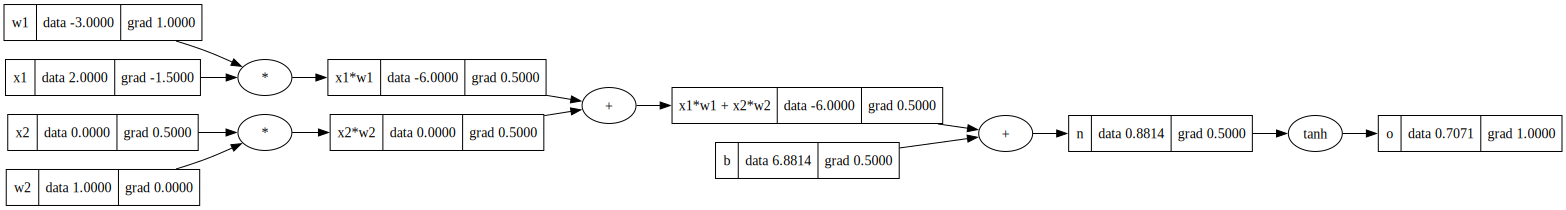

In [8]:
draw_dot (o)

In [9]:
# o = tanh(n)
# do/dn = 1 - tanh(n) ** 2 = 1 - o ** 2

# o.grad = 1.0
# n.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

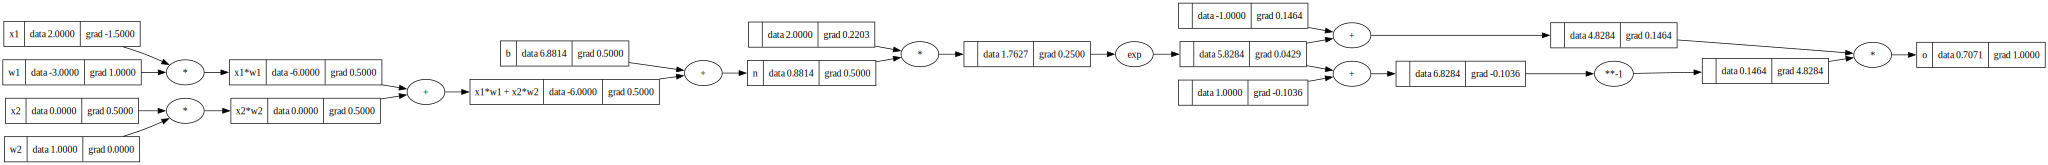

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [11]:
import torch
import random

In [12]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [189]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
len(n.parameters())

41

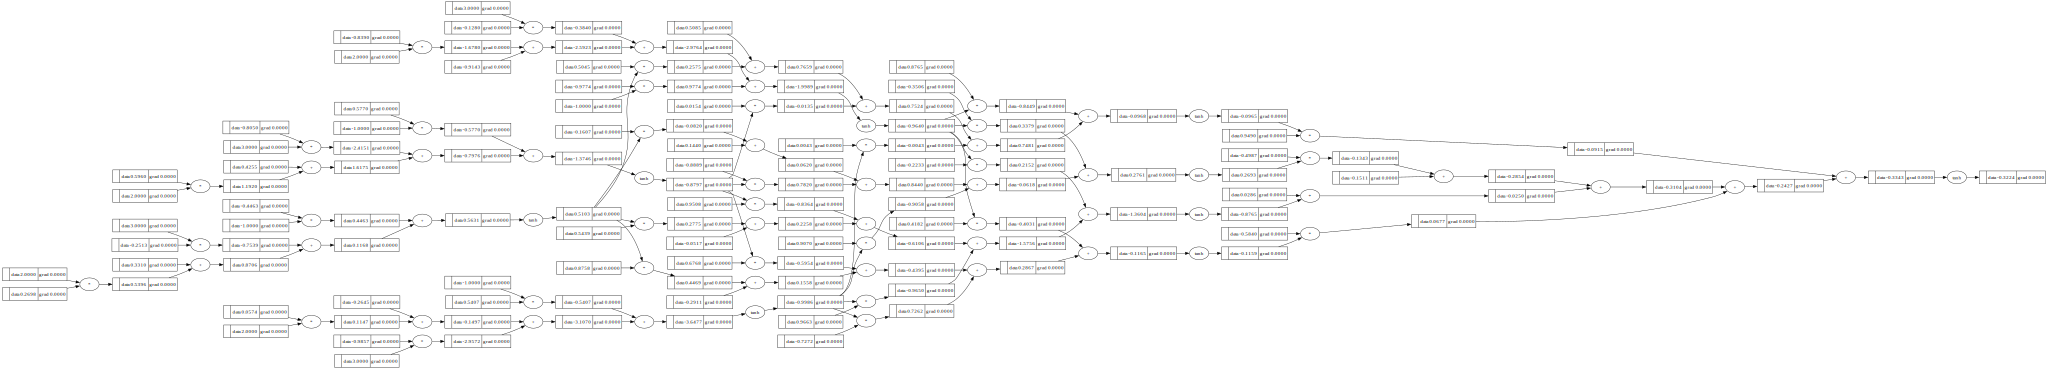

In [190]:
draw_dot(n(x))

In [191]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [201]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.004979943436828542
1 0.004923610841169646
2 0.004868489903140793
3 0.0048145426467458485
4 0.004761732649405669
5 0.004710024963919331
6 0.004659386045057821
7 0.004609783680473581
8 0.004561186925634008
9 0.004513566042509413
10 0.004466892441765801
11 0.004421138628232348
12 0.004376278149429599
13 0.004332285546961072
14 0.004289136310584446
15 0.004246806834792732
16 0.004205274377747178
17 0.004164517022415174
18 0.004124513639777171
19 0.004085243853975313


In [202]:
ypred

[Value(data=0.9723547446778741),
 Value(data=-0.9858173556625137),
 Value(data=-0.9582550662491103),
 Value(data=0.962889397500445)]